# Sentiment Analysis of COVID-19 Vaccine Tweets

![vaccine](media/vaccine_cover.jpeg)

![kaggle_preview](media/kaggle_preview.png)

In [1]:
##################################################################################
#       author:     Sejal Dua                                                    #
#         date:     03/15/2021                                                   #
#  data source:     https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets    #
#      credits:     Ariwan Sri Setya, Tom Whelan, Gabriel Preda                  #
##################################################################################

## Data Access

In [3]:
# installs
!pip install textblob
!pip install wordcloud
!python -m textblob.download_corpora
!pip install plotly
!pip install wordninja
!pip install pyspellchecker

You should consider upgrading via the '/Users/sejaldua/miniconda3/bin/python -m pip install --upgrade pip' command.
Processing /Users/sejaldua/Library/Caches/pip/wheels/f8/f6/55/6bd394c32a844a621ca0fe5dbf563c8d71d71edaf095656991/wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl
You should consider upgrading via the '/Users/sejaldua/miniconda3/bin/python -m pip install --upgrade pip' command.


In [140]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.express as px

In [141]:
df = pd.read_csv("vaccination_all_tweets.csv", quotechar='"', delimiter=',').dropna()
df

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo","End North Stream 2 now - the pipeline of corruption, funding Russias war against Ukraine,Georgia, Syria and political intervention in USA and EU must be stopped",2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",['vaccination'],Twitter Web App,0,4,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafianspower1\n#PoliticalScience #InternationalAffairs \n#PAKUSTV #Newyork #Islamabad,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w","['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",Twitter Web App,0,0,False
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (freelance) for some companies that need analysis for their products in Int. Markets \n- Instagram : tamervisits -",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27802,1368226947822653442,Andy The legally and popularly elected Gardener.,Untidied States,merciless infj door slammer.,2019-01-01 23:12:42,93,83,9876,False,2021-03-06 15:48:19,"If you want to know how much antivaxx disinformation on here is paid for by Russia, search #SputnikV and you’ll see… https://t.co/5ERcFAlHdf",['SputnikV'],Twitter for iPhone,0,1,False
27804,1368224770995675139,🌎 Sarwar 🌐,E,W pirsarwarras,2009-07-01 00:18:11,1685,1439,6268,False,2021-03-06 15:39:40,#BREAKING \n#Venezuela \nVenezuelan President Maduro Gets First Dose of Russian #SputnikV COVID Vaccine… https://t.co/GwVBm0U2RI,"['BREAKING', 'Venezuela', 'SputnikV']",Twitter Web App,0,2,False
27806,1368224272267829256,Workout Solutions,"Toronto, Canada and Worldwide","George Tsanis – Workout Solutions Health and Fitness Consultants since 1996 – One-on-one and online distance coaching – Toronto, Canada, World",2010-09-20 17:01:08,1164,172,1358,False,2021-03-06 15:37:41,Moscow Russia everything is open business as usual. Ontario is reporting 990 cases of #COVID19 284 new cases in Tor… https://t.co/FoTl9TM4Og,['COVID19'],Twitter for iPhone,1,2,False
27807,1368218905353859081,William Owen,"Moscow, Russia",| political | cats | bikes | civil rights | tech | photography,2009-03-16 03:03:13,3962,2594,51923,False,2021-03-06 15:16:21,Of course Black (spits) never mentions #SputnikV - the #ForbiddenVaccine https://t.co/vUme5IZYb2,"['SputnikV', 'ForbiddenVaccine']",Twitter Web App,0,0,False


In [142]:
print(df.columns)
print(df.shape)

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')
(16180, 16)


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16180 entries, 0 to 27808
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                16180 non-null  int64 
 1   user_name         16180 non-null  object
 2   user_location     16180 non-null  object
 3   user_description  16180 non-null  object
 4   user_created      16180 non-null  object
 5   user_followers    16180 non-null  int64 
 6   user_friends      16180 non-null  int64 
 7   user_favourites   16180 non-null  int64 
 8   user_verified     16180 non-null  bool  
 9   date              16180 non-null  object
 10  text              16180 non-null  object
 11  hashtags          16180 non-null  object
 12  source            16180 non-null  object
 13  retweets          16180 non-null  int64 
 14  favorites         16180 non-null  int64 
 15  is_retweet        16180 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.9+ MB


# Data Wrangling & Preprocessing

In [144]:
df.drop(columns=['id'], inplace=True)

In [145]:
df = df.drop_duplicates('text')
print(df.shape)

(16170, 15)


In [146]:
# use regular expressions to strip each tweet of mentions, hashtags, retweet information, and links
def clean_tweet_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = text.lower()
    return text

# the following line makes use of an apply function-- it will call clean_tweet_text on every element in the 'text' column
df['text'].transform(clean_tweet_text)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo","End North Stream 2 now - the pipeline of corruption, funding Russias war against Ukraine,Georgia, Syria and political intervention in USA and EU must be stopped",2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",['vaccination'],Twitter Web App,0,4,False
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafianspower1\n#PoliticalScience #InternationalAffairs \n#PAKUSTV #Newyork #Islamabad,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w","['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",Twitter Web App,0,0,False
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (freelance) for some companies that need analysis for their products in Int. Markets \n- Instagram : tamervisits -",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


In [147]:
# we do not care about the exact time of each tweet, we just want the date
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo","End North Stream 2 now - the pipeline of corruption, funding Russias war against Ukraine,Georgia, Syria and political intervention in USA and EU must be stopped",2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",['vaccination'],Twitter Web App,0,4,False
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafianspower1\n#PoliticalScience #InternationalAffairs \n#PAKUSTV #Newyork #Islamabad,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w","['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",Twitter Web App,0,0,False
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (freelance) for some companies that need analysis for their products in Int. Markets \n- Instagram : tamervisits -",2009-09-17 16:45:16,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


# Exploratory Data Analysis (EDA)

In [148]:
df.describe()

,user_followers,user_friends,user_favourites,retweets,favorites
count,1.617000e+04,16170.000000,16170.000000,16170.000000,16170.000000
mean,1.719752e+05,1518.035931,14619.516079,4.241187,18.428386
std,1.141814e+06,7640.144298,37054.083845,45.617605,246.240119
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.180000e+02,170.000000,426.000000,0.000000,0.000000
50%,9.470000e+02,492.500000,2377.000000,0.000000,1.000000
75%,4.284000e+03,1372.750000,11847.250000,1.000000,5.000000
max,1.486666e+07,380428.000000,686342.000000,2360.000000,22815.000000


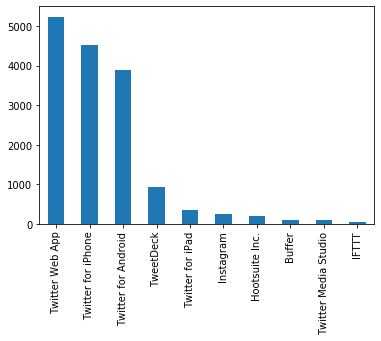

In [149]:
# which device are people tweeting about the vaccine from?
df['source'].value_counts().head(n=10).plot.bar()

In [150]:
# what are the top 10 most retweeted tweets
pd.set_option('display.max_colwidth', 400)
df.sort_values(by='retweets', ascending=False)[['text', 'date', 'user_name', 'user_location', 'hashtags', 'favorites', 'retweets']].head(n=10)

,text,date,user_name,user_location,hashtags,favorites,retweets
17118,"Got my jab. For the curious, it was #Covaxin. \n\nFelt secure, will travel safely. https://t.co/8PL7PZMEsf",2021-03-01,Dr. S. Jaishankar,"New Delhi, India",['Covaxin'],22815,2360
7126,"New research published in Microbiology &amp; Infectious Diseases, immunologist J. Bart Classen warns #mRNA technology u… https://t.co/OWUTf5ShHO",2021-02-10,Robert F. Kennedy Jr,"Los Angles, California",['mRNA'],3090,2247
26737,"#Covaxin 🇮🇳 , made by Hyderabad-based Bharat Biotech International Limited, has been declared ""Safe, Immunogenic wi… https://t.co/FAUOEHJmAw",2021-03-09,Megh Updates 🚨,Turn on Notification 🔔,['Covaxin'],9457,2092
17543,Prime Minister Narendra Modi choose early morning time to take #covaxin . No traffic was stopped . Traveled normall… https://t.co/udxAqk9xEC,2021-03-01,Megh Updates 🚨,Turn on Notification 🔔,['covaxin'],8153,1980
27709,This is not a queue for a Covid vaccine\nThis is a queue at a food bank today in the UK.\n#coronavirus #oxfordvaccine… https://t.co/rGqg14FT9t,2021-03-08,Afshin Rattansi,London,"['coronavirus', 'oxfordvaccine']",1713,1514
20965,#BREAKING : Bharat Biotech says its #Covaxin shows interim clinical efficacy of 81% in Phase 3 results,2021-03-03,Megh Updates 🚨,Turn on Notification 🔔,"['BREAKING', 'Covaxin']",6651,938
20575,It is tough when have to play the sauve Amrikan doctor but ur desi Lahore genes start acting up #Covaxin https://t.co/ZUygPW4WGd,2021-03-03,Manoj Rawat,New Delhi,['Covaxin'],3636,922
13101,AIIMS nurse who gave the #Covaxin jab to Prime Minister @narendramodi speaks to the national broadcaster DD News ab… https://t.co/ivPj4KGiyE,2021-03-01,Aditya Raj Kaul,"New Delhi, India",['Covaxin'],5827,870
21568,"The Opposition campaign to denigrate #Covaxin is disgraceful. So is the refusal by a coterie of senior editors, col… https://t.co/yN6M1BxvCn",2021-03-05,Minhaz Merchant,Mumbai,['Covaxin'],2311,806
20964,Phase 3 Results of #COVAXIN - announced by @BharatBiotech : Demonstrates Interim Clinical Efficacy of 81%,2021-03-03,Prof Shamika Ravi,"New Delhi, Kannauj, Kohima",['COVAXIN'],5575,773


# Sentiment Analysis

We will be using the `TextBlob` library to perform sentiment analysis on the tweets in our dataset. `TextBlob` provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. That said, there are numerous other packages with similar capabilities that are worth exploring, including `sklearn`, `nltk`, `vader`, `allennlp`, and more.

Let's do a simple example!

In [151]:
# tweet from Texas Governor Greg Abbott
text = """
Today Texas surpassed 8 million vaccinations. It was just 4 days ago that we passed 7 million.

The positivity rate dropped even lower--to 6.08%--the lowest since May 31st.

Hospitalizations went down again also.

Great job Texans!

Vaccines are always voluntary, never forced.
"""
blob = TextBlob(text)

In [152]:
print("Tags")
print(blob.tags, end="\n\n")

print("Noun Phrases")
print(blob.noun_phrases, end="\n\n")

print("Words")
print(blob.words, end="\n\n")

print("Sentences")
print(blob.sentences, end="\n\n")

Tags
[('Today', 'NN'), ('Texas', 'NNP'), ('surpassed', 'VBD'), ('8', 'CD'), ('million', 'CD'), ('vaccinations', 'NNS'), ('It', 'PRP'), ('was', 'VBD'), ('just', 'RB'), ('4', 'CD'), ('days', 'NNS'), ('ago', 'RB'), ('that', 'IN'), ('we', 'PRP'), ('passed', 'VBD'), ('7', 'CD'), ('million', 'CD'), ('The', 'DT'), ('positivity', 'NN'), ('rate', 'NN'), ('dropped', 'VBD'), ('even', 'RB'), ('lower', 'JJR'), ('to', 'TO'), ('6.08', 'CD'), ('%', 'NN'), ('the', 'DT'), ('lowest', 'JJS'), ('since', 'IN'), ('May', 'NNP'), ('31st', 'CD'), ('Hospitalizations', 'NNS'), ('went', 'VBD'), ('down', 'RB'), ('again', 'RB'), ('also', 'RB'), ('Great', 'NNP'), ('job', 'NN'), ('Texans', 'NNPS'), ('Vaccines', 'NNS'), ('are', 'VBP'), ('always', 'RB'), ('voluntary', 'JJ'), ('never', 'RB'), ('forced', 'VBN')]

Noun Phrases
['texas', 'positivity rate', 'may', 'hospitalizations', 'great job', 'vaccines']

Words
['Today', 'Texas', 'surpassed', '8', 'million', 'vaccinations', 'It', 'was', 'just', '4', 'days', 'ago', 'that'

In [153]:
for sentence in blob.sentences:
    print(sentence)
    print("polarity:", sentence.sentiment.polarity)
    print("subjectivity:", sentence.sentiment.subjectivity)
    print()


Today Texas surpassed 8 million vaccinations.
polarity: 0.0
subjectivity: 0.0

It was just 4 days ago that we passed 7 million.
polarity: 0.0
subjectivity: 0.0

The positivity rate dropped even lower--to 6.08%--the lowest since May 31st.
polarity: 0.0
subjectivity: 0.0

Hospitalizations went down again also.
polarity: -0.15555555555555559
subjectivity: 0.2888888888888889

Great job Texans!
polarity: 1.0
subjectivity: 0.75

Vaccines are always voluntary, never forced.
polarity: 0.15000000000000002
subjectivity: 0.2



In [154]:
# let's apply the TextBlob API onto our tweet data to perform sentiment analysis!
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity
0,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False,0.00,0.125000
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False,0.00,0.033333
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo","End North Stream 2 now - the pipeline of corruption, funding Russias war against Ukraine,Georgia, Syria and political intervention in USA and EU must be stopped",2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",['vaccination'],Twitter Web App,0,4,False,-0.10,0.500000
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafianspower1\n#PoliticalScience #InternationalAffairs \n#PAKUSTV #Newyork #Islamabad,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w","['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",Twitter Web App,0,0,False,0.00,0.000000
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (freelance) for some companies that need analysis for their products in Int. Markets \n- Instagram : tamervisits -",2009-09-17 16:45:16,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,0.25,0.333333


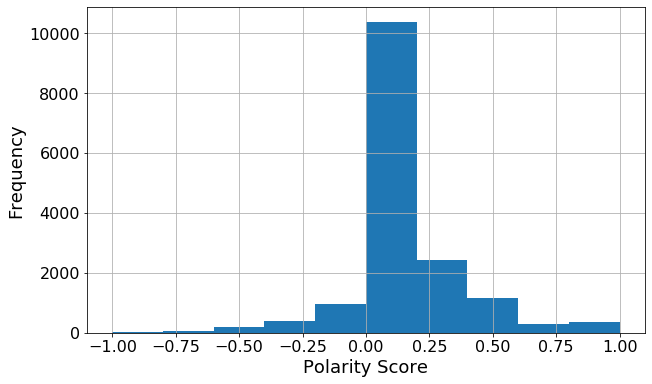

In [155]:
fig = plt.figure(figsize=(10, 6))
df['polarity'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("./figures/polarity_hist.png")

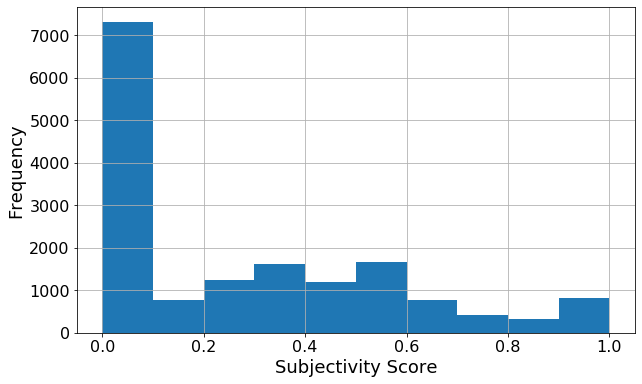

In [156]:
fig = plt.figure(figsize=(10, 6))
df['subjectivity'].hist()
plt.xlabel('Subjectivity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("./figures/subjectivity_hist.png")

## Inspection

In [157]:
# inspect the most negatively charged tweets
df.sort_values(by='polarity', ascending=True)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,@AblemanAdam Terrible! Thank-you! And here in Canada @JustinTrudeau still will not call Russia for some #SputnikV,-1.0,1.0
1,Pharmaceutical greed at its worst...\n\n#PfizerBioNTech \n\nhttps://t.co/nT98jdzMlj,-1.0,1.0
2,"Day 4 w/#Moderna (shot 1)..\nugh, i'm miserable, but ironically i have never had any injection site pain or swelling… https://t.co/H8jo9i4wl8",-1.0,1.0
3,#Moderna side effects were terrible head aches and sore arm/injection site. The head aches may have been bc I was i… https://t.co/AWnTJP3LZB,-1.0,1.0
4,Outrageous that #Moderna #vaccine not approved in #Japan weeks ago. This isn’t the fault of #Moderna or the #EU or… https://t.co/UI0RtbMkJW,-1.0,1.0
5,Death of 23 people's in #Norway after receiving #PfizerBioNTech vaccine is pathetic and scarry too!! Autopsy report… https://t.co/N36GJTVDPP,-1.0,1.0
6,@ShamikaRavi @BharatBiotech Shocking #clinicaltrials of COVAXIN #COVID19Vaccine. Signs of #Covaxin recipients taken… https://t.co/kWLuW6tz0i,-1.0,1.0
7,@gurpreetscheema @Milan_reports @BharatBiotech @IndiaToday Shocking #clinicaltrials of COVAXIN #COVID19Vaccine. Sig… https://t.co/1Baj3QqeRk,-1.0,1.0
8,#PfizerBioNTech #Vaccin #COVID19 #Moderna \nWHAT THE FUCK !!!!!!\n😂😂😂😂🤣🤣🤣🤣🤣😱😱😱😱😱 https://t.co/NaPnpvhY5W,-1.0,0.6
9,Got my #Moderna Covid-19 vaccine dose 2 yesterday and today I feel like crap! 🤕 I do feel blessed to have had the o… https://t.co/8WfXUodIJJ,-1.0,0.8


In [158]:
# inspect the most positively charged tweets
df.sort_values(by='polarity', ascending=False)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,Help us win this battle - Register to get yours ! #covid19 #PfizerBioNTech #HDF https://t.co/rVbjIfQvIX,1.0,0.40
1,Questions in 🇧🇦 on whether the authorities agreed on the best conditions when buying #SputnikV🇷🇺 vaccines continue.… https://t.co/74RsA9KxwM,1.0,0.30
2,This would be great news!\n#COVID19 #vaccines #Pfizer #Moderna https://t.co/s8QCK50Pbp,1.0,0.75
3,"He took #COVAXIN, against which a lot of misinformation was spread even when it was scientifically perfect. I think… https://t.co/0RyKiFMK6l",1.0,1.00
4,Great!\n#Covaxin \n#COVID19 https://t.co/KTVPEYTHFR,1.0,0.75
5,@ARanganathan72 Excellent work #Bharat 👏\n#Covaxin \n\nCan we help our forever skeptics &amp; critics as… https://t.co/ppBYyIWKeK,1.0,1.00
6,#Covid19 Excellent news 👏👏👏\nCongratulations @BharatBiotech\n\nExpert panel recommends dropping ‘clinical trial mode’… https://t.co/eqjhQUe0Px,1.0,1.00
7,"I'm thoroughly impressed by PM @narendramodi's commitment. He took the #COVAXIN shot by #BharatBiotech, leading by… https://t.co/eQUlWc92Wb",1.0,1.00
8,Very happy to have been given the 1st dose of the #PfizerBioNTech #CovidVaccine today at @NewcastleHosps RVI. Amazi… https://t.co/SkMCQzlZZA,1.0,1.00
9,"Just got vaccinated, and feel great about it! #moderna dose 1 https://t.co/RhkBKukPfz",1.0,0.75


In [159]:
# inspect the most subjective tweets (NOTE: subjectivity scale ranges from 0 to 1)
df.sort_values(by='subjectivity', ascending=True)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,"2nd vaccine received today, thank you @OUHospitals #PfizerBioNTech #covid19 #OneTeamOneOUH #NurseTwitter https://t.co/OoTZpQCQq8",0.0,0.0
1,"article #compares #benefits of #Pfizer, #Moderna and #Johnson and Johnson #vaccines https://t.co/FaNr6YgI2W",0.0,0.0
2,#Thursday “Ok. I was watching @12News it says the “#johnsonandjohnson #COVID19Vaccine is a one shot vaccine. Howeve… https://t.co/nx1HoyM8GL,0.0,0.0
3,Hey #Chicago..\n\nHeads up ! #COVID19 vaccine.\n\n#Moderna https://t.co/0O8Wmo92Ac,0.0,0.0
4,"For everyone passing on the #Moderna and #Pfizer vaccines to wait for the #johnsonandjohnson vaccine, please rememb… https://t.co/ChLtt6XWOv",0.0,0.0
5,The complexities of international politics hit #publichealth and #humanrights once again: \n\nSurplus #doses of… https://t.co/nxIXuDzWWb,0.0,0.0
6,$MRNA 🇺🇸 #Moderna expects $18.4 billion in 2021 sales https://t.co/ToP0BXS1bh,0.0,0.0
7,@CDCgov is lower back pain a side effect of the @moderna_tx COVID vaccine cause...\n\nOw #COVID19Vaccine #Moderna,0.0,0.0
8,Also I got second dose #COVIDVaccine today #modernavaccine #Moderna,0.0,0.0
9,Jean Marie will #Moderna-ize me https://t.co/4wfFqOmv28,0.0,0.0


In [160]:
# inspect the most objective tweets
df.sort_values(by='subjectivity', ascending=False)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,@Pfizer_France Here's manufacture @Pfizer_France #PfizerBioNTech ! @SanofiFR changes : 3 months to make it ! We don… https://t.co/lDNPYF5wyw,0.625,1.0
1,@KyleClark @nexton9news Important #COVID19 #vaccine question: Can someone who already received #Pfizer or #Moderna… https://t.co/MFJY5TxVsf,0.400,1.0
2,Covid: India could play an important role in producing vaccines https://t.co/RYZ9dyOXJY\n\n@Ocugen #BharatBiotech… https://t.co/vDTCpJJveH,0.400,1.0
3,Covid-19 Vaccine: Only 1 in 10 Take Jab After Four Weeks\n\n#vaccine #COVID19 #coronavirus #CoronaVaccine #India… https://t.co/K1YpYKcxJ5,0.000,1.0
4,Quote for today\nSayin' it as it is!\n#DollyParton #inspirational #Acceptance #nolimits #Moderna #jobsearcg #GoForIt… https://t.co/Gp8sSuGqVc,0.500,1.0
5,Finally got my vaccine today it hurt like a bitch and she even drew blood 😢 😝 #COVIDVaccination #oxfordastrazeneca 💉,0.000,1.0
6,"#SputnikV in India is &gt; 10 and in #Pakistan, only the businessman friend of #ImranKhan knows. https://t.co/zBTskSQ4uN",0.000,1.0
7,Never have I seen a group of people so happy in a pharmacy before or people so happy to get shots. #CovidVaccine… https://t.co/Rx7mHzGSUs,0.800,1.0
8,"@CBCNews Mayor of Nice in France asks health authorities to permit him to buy Russia #COVID19 vaccine #SputnikV, Wh… https://t.co/GZw9G5fhnN",0.600,1.0
9,I got the shot! #Moderna Relieved and happy to finally see the end for all of us 🙏 https://t.co/DTQFrAJwxH,0.400,1.0


In [161]:
# let's inspect how many tweets there were with respect to time
timeline = df.groupby(['date']).count().reset_index()
timeline['count'] = timeline['text']
timeline = timeline[['date', 'count']]
fig = px.bar(timeline, x='date', y='count', labels={'date': 'Date', 'count': 'Tweet Count'})
fig.show()
# fig.write_image("./figures/tweet_freq_over_time.png")

# Time-Series Sentiment Analysis

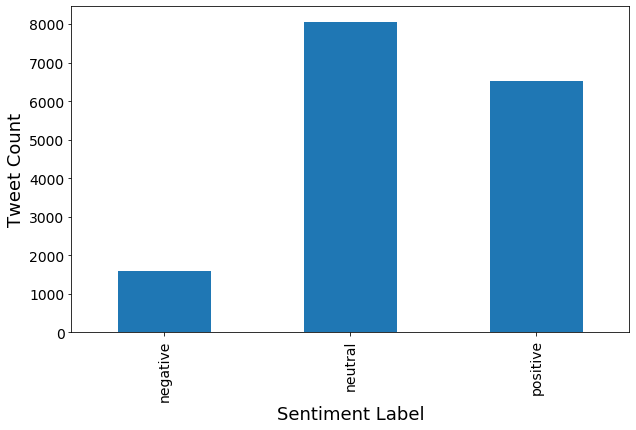

<Figure size 432x288 with 0 Axes>

In [162]:
# polarity values ranging from -1 to 1 are really useful for sentiment analysis
# but let's convert our data to 3 classes (negative, neutral, and positive) so that we can visualize it
criteria = [df['polarity'].between(-1, -0.01), df['polarity'].between(-0.01, 0.01), df['polarity'].between(0.01, 1)]
values = ['negative', 'neutral', 'positive']
df['sentiment'] = np.select(criteria, values, 0)

# plot sentiment counts
fig = plt.figure(figsize=(10, 6))
df['sentiment'].value_counts().sort_index().plot.bar()
plt.xlabel('Sentiment Label', fontsize=18)
plt.ylabel('Tweet Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.tight_layout()
fig.savefig("./figures/sentiment_value_counts", bbox_inches='tight');

In [163]:
timeline = df.groupby(['date']).agg(np.nanmean).reset_index()
timeline['count'] = df.groupby(['date']).count().reset_index()['retweets']
timeline = timeline[['date', 'count', 'polarity', 'retweets', 'favorites', 'subjectivity']]
timeline["polarity"] = timeline["polarity"].astype(float)
timeline["subjectivity"] = timeline["subjectivity"].astype(float)
timeline

,date,count,polarity,retweets,favorites,subjectivity
0,2020-12-12,38,0.034952,0.631579,2.868421,0.227801
1,2020-12-13,52,0.055937,1.942308,7.500000,0.255696
2,2020-12-14,83,0.116874,4.698795,29.204819,0.267803
3,2020-12-15,87,0.094041,1.022989,7.333333,0.258078
4,2020-12-16,78,0.104020,1.000000,5.115385,0.248872
...,...,...,...,...,...,...
88,2021-03-10,465,0.098784,2.481720,9.987097,0.246851
89,2021-03-11,516,0.081946,2.232558,9.248062,0.253772
90,2021-03-12,467,0.108128,1.391863,8.509636,0.259496
91,2021-03-13,315,0.088139,3.161905,11.838095,0.290822


In [164]:
# Plot tweets over time, color-coded by average polarity score
fig = px.bar(timeline, x='date', y='count', color='polarity')
fig.show()

In [165]:
# # Plot tweets over time, color-coded by average subjectivity score
fig = px.bar(timeline, x='date', y='count', color='subjectivity')
fig.show()

# Filter by Vaccy

In [166]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine-- not very helpful!
def filter_by_vaccy(df, vax):
    df_filt = pd.DataFrame()
    for v in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(v)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date']).agg(np.nanmean).reset_index()
    timeline['count'] = df_filt.groupby(['date']).count().reset_index()['retweets']
    timeline = timeline[['date', 'count', 'polarity', 'retweets', 'favorites', 'subjectivity']]
    timeline["polarity"] = timeline["polarity"].astype(float)
    timeline["subjectivity"] = timeline["subjectivity"].astype(float)
    return df_filt, timeline

In [167]:
pfizy_df, pfizy_timeline = filter_by_vaccy(df, ['pfizer'])
print(pfizy_df.shape)
fig = px.bar(pfizy_timeline, x='date', y='count', color='polarity')
fig.show()

(245, 18)


In [168]:
moderna_df, moderna_timeline = filter_by_vaccy(df, ['moderna'])
print(moderna_df.shape)
fig = px.bar(moderna_timeline, x='date', y='count', color='polarity')
fig.show()

(2604, 18)


In [169]:
astra_df, astra_timeline = filter_by_vaccy(df, ['astrazeneca'])
astra_df.sort_values(by='polarity', ascending=True).reset_index(drop=True).head(n=20)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity,sentiment
0,Ricarda Milstein,Hamburg - Berlin,Health Economist @unihh/@hche_uhh. Passion for Asia and baroque music. All views are my own. RT ≠ endorsement.,2014-09-24 20:22:30,388,387,3863,False,2021-02-17,The @tagesspiegel reports that only 2% of 🇩🇪 would choose #AstraZeneca. Thank god it's not that bad: Approx. 50% ar… https://t.co/ZE2hnjtGTG,['AstraZeneca'],Twitter Web App,8,10,False,-0.350000,0.833333,negative
1,Bart Kulpa,"London, UK","Globally-minded person working for an international law firm. Enjoy debate on law, politics and foreign affairs 🇪🇺🇵🇱🇬🇧",2014-03-14 15:46:47,3951,3938,40651,False,2021-03-05,"In AstraZeneca spat, EU fights hard for a vaccine it's hardly using https://t.co/430WB67N7a #Europe #EU… https://t.co/FQVqMKZMyw","['Europe', 'EU']",Twitter for Android,1,0,False,-0.291667,0.541667,negative
2,Anurag Sinha,"Ottawa, Canada",International Affairs; Itinerant ✈️🇲🇹 ✈️ 🇬🇧 ✈️ 🇶🇦✈️ 🇵🇱 ✈️ 🇩🇪 ✈️ 🇪🇸 ✈️ 🇦🇹 ✈️🇨🇭✈️ 🇨🇾,2008-11-04 14:47:14,360,3314,5546,False,2021-02-10,@szarabi Not sure what you mean by India-made. #AstraZeneca has been approved @GovCanHealth. We in #Canada don’t re… https://t.co/Rjy8VvWYNu,"['AstraZeneca', 'Canada']",Twitter for iPhone,0,2,False,-0.281250,0.788194,negative
3,EurAsian Times,Global,"EurAsian Times provides Latest International News and Analysis besides Empowering People to Report, Review & Publish Online Consumer Complaints.",2014-11-18 09:13:11,3017,132,3,False,2021-03-03,#Malaysia granted conditional approval for the use of coronavirus vaccines produced by #UK firm #AstraZeneca and… https://t.co/thlavGJdsJ,"['Malaysia', 'UK', 'AstraZeneca']",Twitter Web App,1,1,False,-0.200000,0.400000,negative
4,Michael Wynne,Bahrain,Views and opinions are my own. You are entitled to your own.,2011-02-09 00:47:27,192,725,3668,False,2021-03-04,@caulmick Independent... me hole... Seriously the EU has been screwed over by #AstraZeneca and people will end up i… https://t.co/e6BmyoFuzz,['AstraZeneca'],Twitter for iPhone,1,1,False,-0.166667,0.395833,negative
5,India Post,"Fremont, CA, USA",Refresh yourself every morning with India Post news coverage Use#IndiaPostNewsPaper to get featured\nContribute your articles here: https://t.co/yuBlQ7dX1S…,2009-03-24 20:03:31,628,699,15,False,2021-02-08,AstraZeneca's vaccine less ... - https://t.co/TE9RYY5PgP \nGet your news featured use #IndiaPostUSA \n#AnthonyFauci… https://t.co/BjG0kZHBfe,"['IndiaPostUSA', 'AnthonyFauci']",IndiaPost,0,0,False,-0.166667,0.066667,negative
6,Ramon Denz,Gaza,Free Palestine - Friend of Muslims - ANTI Racism and Fascism - can't stand stupid people - 9/11 was an inside job!\nAKASHIC VAULT,2020-07-08 10:09:23,263,502,10990,False,2021-02-08,"#AstraZeneca proofs to be NOT functioning at all, and pointless to take to stop #Corona. How long will it take befo… https://t.co/etBr4YqlSJ","['AstraZeneca', 'Corona']",Twitter Web App,0,0,False,-0.150000,0.450000,negative
7,Dr George Christos,"Perth, Western Australia","theoretical physicist/mathematician/neuroscientist/author artist/builder/architectural artist\n2020s: #covid19 covidologist, go4 #zerocovid",2015-05-31 11:15:30,861,89,7199,False,2021-03-05,i still cannot see what we are using #AstraZeneca #vaccine which has a much lower #efficacy and useless against som… https://t.co/jbS1JTBg5o,"['AstraZeneca', 'vaccine', 'efficacy']",Twitter Web App,0,1,False,-0.150000,0.200000,negative
8,🕷Financial Bear 3.5%,#KeepFightingMichael,"Pro the EU for the opportunities it offers citizens.Lower tax,less authority, power to the people not politicians. Love coffee,running, Formula-E",2012-03-10 08:03:36,1677,899,29431,False,2020-12-30,#AstraZeneca vaccine is going to have a communications nightmare due to their rush under government pressure to rel… https://t.co/qyt1Vt3Bga,['AstraZeneca'],Twitter Web App,1,0,False,-0.1250

In [170]:
covaxin_df, covaxin_timeline = filter_by_vaccy(df, ['covaxin'])
covaxin_df.sort_values(by='polarity', ascending=True).reset_index(drop=True).head(n=20)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity,sentiment
0,Prasenjit Bhakat,"Jhargram,W Bengal,India","Past President (2011-12): Rotary Jhargram Green, Rotary Int'l Dist 3291;\r\n \r\n\r\n\r\n\r\n\r\n\r\n\r\nConsumer Activist,Secretary: Consumer Guidance Center.",2009-08-31 02:14:30,390,1658,5071,False,2021-03-03,@ShamikaRavi @BharatBiotech Shocking #clinicaltrials of COVAXIN #COVID19Vaccine. Signs of #Covaxin recipients taken… https://t.co/kWLuW6tz0i,"['clinicaltrials', 'COVID19Vaccine', 'Covaxin']",Twitter Web App,0,0,False,-1.000000,1.000000,negative
1,Prasenjit Bhakat,"Jhargram,W Bengal,India","Past President (2011-12): Rotary Jhargram Green, Rotary Int'l Dist 3291;\r\n \r\n\r\n\r\n\r\n\r\n\r\n\r\nConsumer Activist,Secretary: Consumer Guidance Center.",2009-08-31 02:14:30,390,1658,5071,False,2021-03-03,@gurpreetscheema @Milan_reports @BharatBiotech @IndiaToday Shocking #clinicaltrials of COVAXIN #COVID19Vaccine. Sig… https://t.co/1Baj3QqeRk,"['clinicaltrials', 'COVID19Vaccine']",Twitter Web App,0,0,False,-1.000000,1.000000,negative
2,Balaji,Bengaluru,"Classical Liberal. Wry wit, that usually fails.",2008-08-07 17:03:25,487,148,5278,False,2021-03-01,Prime Moron.\n\nTerrible advertisement for research in India when the Prime Minister takes #Covaxin which was not exp… https://t.co/kAdzjuVTXN,['Covaxin'],Twitter for iPhone,0,1,False,-0.900000,1.000000,negative
3,Dilip Jain | दिलीप जैन 🇮🇳,"Bengaluru, India",Entrepreneur ● Love Cooking ● Blessed To Be Followed By PM Narendra Modi & Sh Amit Shah ● #JaiHind 🇮🇳,2010-05-09 18:31:09,13869,410,80561,False,2021-03-01,"@tinucherian @narendramodi Hello hate machine, its Bharath Biotech #COVAXIN https://t.co/ZeeDowMLbs",['COVAXIN'],Twitter for Android,5,133,False,-0.800000,0.900000,negative
4,Balaji Ganesan,"Bengaluru, India","Engineer @IBMResearch. Interested in Knowledge Graphs, NLP and Information Retrieval.",2010-06-19 08:20:41,373,370,868,False,2021-03-01,"Nature doesn’t play dice.\n\nIn India, Govt does. To choose whether a person gets #covishield or #Covaxin.\n\nBad adver… https://t.co/HEct4o0syr","['covishield', 'Covaxin']",Twitter for iPhone,0,2,False,-0.700000,0.666667,negative
5,#SETTARGETS 🎯,"London, England","⏳ It's a marathon, not a sprint. 💎 Do your own DD and #TAKEPROFIT —— $IDEX $OCGN $CBBT $NIO $ACIC $LAC $LTMCF ⚡️ $LINK $ETH $BTC",2021-01-04 12:59:10,57,157,731,False,2021-03-01,WHERE THE FUCK IS @CNN NOW! Report on this news about #COVAXIN you idiots. $OCGN https://t.co/Bhwxbm0jOy,['COVAXIN'],Twitter for iPhone,0,5,False,-0.650000,0.700000,negative
6,NAV BHARAT,"New Delhi, India",जाति 👉 प्रातः- शूद्र || फिर ब्राह्मण || फिर वैश्य || और देशद्रोहियों के लिए सदैव क्षत्रिय।,2014-01-05 15:15:18,292,750,11592,False,2021-03-04,Request @theJagmeetSingh to have one made in india vaccine into his fucking ass also... 😜 #Covaxin #CoronaVaccine… https://t.co/iM1HPSJhWJ,"['Covaxin', 'CoronaVaccine']",Twitter for iPhone,1,1,False,-0.600000,0.800000,negative
7,ब्रह्मराक्षस👹,Gorakhpur & New Delhi,"∣ ɴᴀᴛɪᴏɴ ғɪʀsᴛ 🇮🇳 |\n॥एकोऽहम् द्वितीयो नास्ति, न भूतो न भविष्यति॥\n#DelhiUniversity (Hons.) Chemistry⚗\n| Rajdhanian | In Search of My Destiny ∣ memes❤️ |",2018-09-24 15:09:08,1065,1015,1831,False,2021-03-01,When you are afraid of taking injection bt there are girls all around you😜😆🤣\n#Covaxin #CoronaVaccine… https://t.co/8rlezlrBBn,"['Covaxin', 'CoronaVaccine']",Twitter for Android,0,2,False,-0.600000,0.900000,negative
8,MaryRobotic,"California, United States","Mask-loving, Trump-hating liberal\nopposed to genetic vaccines🌲🌲\nWarp Speed denied U.S. access \nto traditional vaccines.\nUntil a vaccine there's Ivermectin",2019-03-25 17:58:43,79,1,9461,False,2021-03-02,@Yalpanam10 @bsindia Please send all of the #Covaxin doses that you don't want over to the U.S. We are desperate h… https://t.co/rgqTS0YhMV,['Covaxin'],Twitter Web App,0,2,False,-0.600000,1.0

# Wordclouds

In [128]:
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
import math
import random
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Simple

(-0.5, 999.5, 499.5, -0.5)

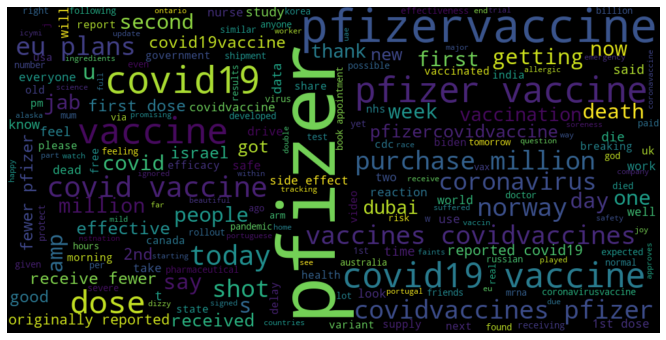

In [129]:
tweet_df = pfizy_df
words = ' '.join([word for word in tweet_df['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

## Advanced

In [171]:
def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    # print(top_n_words)
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud

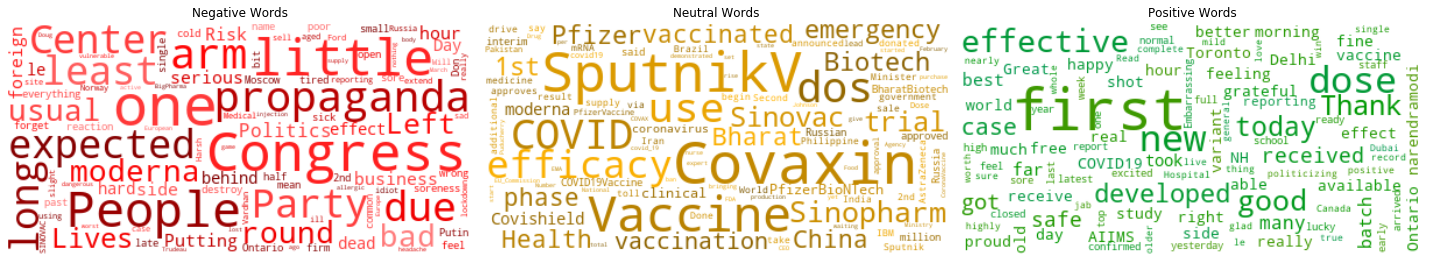

In [172]:
def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    
# Convert string to a list of words
wordcloud_df = df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df)

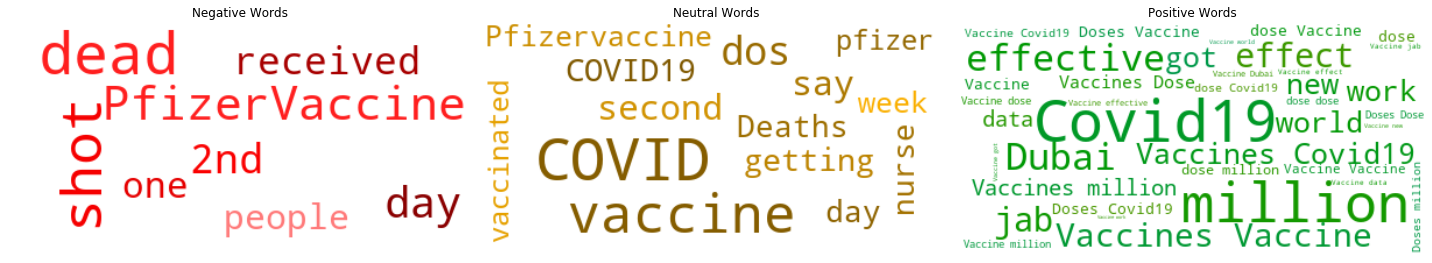

In [173]:
wordcloud_df = pfizy_df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df)

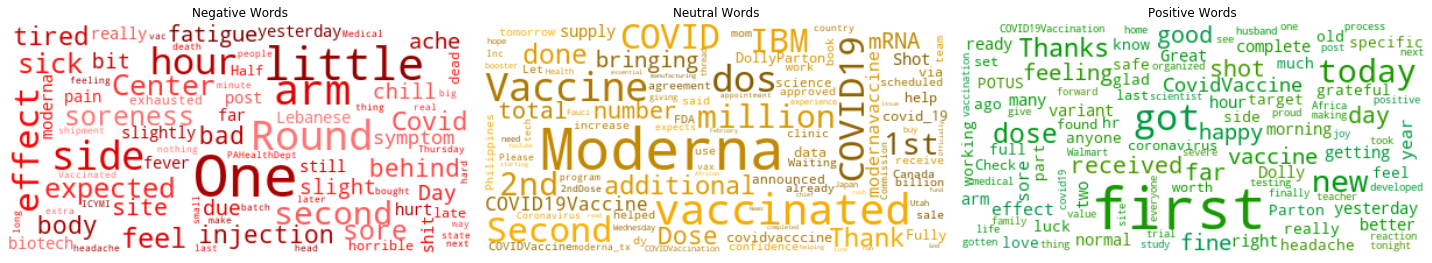

In [174]:
wordcloud_df = moderna_df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df)

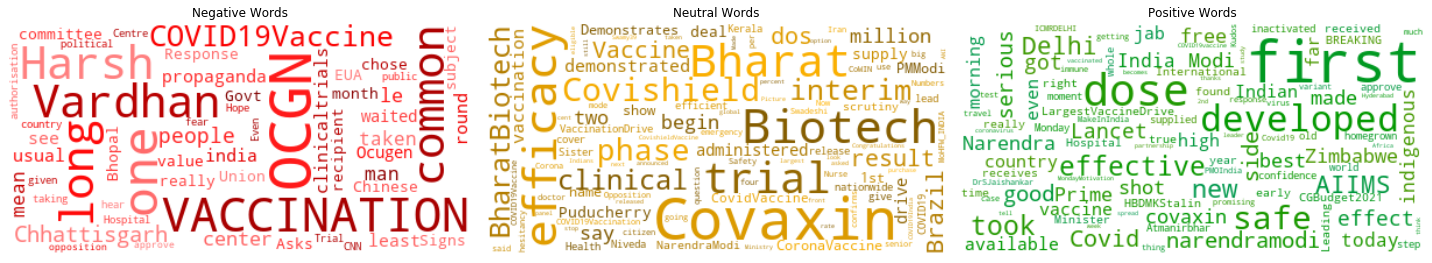

In [175]:
wordcloud_df = covaxin_df
wordcloud_df['words'] = wordcloud_df.text.apply(lambda x:re.findall(r'\w+', x ))
get_smart_clouds(wordcloud_df)

# Insert Cool Sh!t Here

If you wish to go on beyond the scope of this notebook, this is the place to do it. Ideas for extension projects:


*   Use the  `tweepy` [API](https://docs.tweepy.org/en/latest/) to get tweets about the Johnson & Johnson Vaccine, and apply your sentiment analysis onto them.
*   Make some of these visualizations better.
*   Do a quick analysis of hashtag usage
*   What are verified Twitter users saying about the COVID-19 vaccine?
*   What are people saying with respect to side effects? How could you filter the dataset to examine this subtopic?
*   Correlate the [COVID-19 World Vaccination Progress dataset](https://www.kaggle.com/gpreda/covid-world-vaccination-progress) with your sentiment analysis to monitor how attitudes are changing towards the vaccine as the rollout continues.
*   If you know any ML techniques, try to make a model! Then tell us what you did!

